In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.survival_utilities as su
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

### Results for gene expression vs. DNA methylation comparison

In [2]:
# significance cutoff, after FDR correction
SIG_ALPHA = 0.05

# if True, save figures to images directory
SAVE_FIGS = True
images_dir = Path(cfg.images_dirs['survival'])

# set results directory
me_results_dir = Path(cfg.repo_root,
                      '06_predict_survival',
                      'results_extended_alphas')

# set list of PCA component numbers to look for
pcs_list = [10, 100, 500, 1000, 5000]

# order to plot data types in
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
}

In [3]:
me_data_count_df = []

for n_dim in pcs_list:
    # load results into a single dataframe
    me_pcs_dir = Path(me_results_dir, 'results_{}_pca'.format(n_dim))
    me_results_df = su.load_survival_results(me_pcs_dir)
    me_results_df.rename(columns={'identifier': 'cancer_type',
                                  'fold_no': 'fold'}, inplace=True)
    
    me_count_df = (me_results_df[me_results_df.data_type == 'test']
        .groupby(['cancer_type', 'training_data'])
        .count()
    )
    problem_df = me_count_df[me_count_df['cindex'] != 16].copy()
    drop_cancer_types = problem_df.index.get_level_values(0).unique().values
    
    me_all_results_df = au.compare_all_data_types(
        me_results_df[~me_results_df.cancer_type.isin(drop_cancer_types)],
        SIG_ALPHA,
        identifier='cancer_type',
        metric='cindex')
    
    print(n_dim)
    num_reject = me_all_results_df.groupby(['training_data']).sum().reject_null
    num_total = me_all_results_df.groupby(['training_data']).count().reject_null
    
    dim_count_df = (
            pd.DataFrame(num_reject).rename(columns={'reject_null': 'num_reject'})
        .merge(
            pd.DataFrame(num_total).rename(columns={'reject_null': 'num_total'})
        , left_index=True, right_index=True)
    )
    dim_count_df['n_dim'] = n_dim
    dim_count_df['ratio'] = dim_count_df.num_reject / dim_count_df.num_total
    me_data_count_df.append(dim_count_df)
    
me_data_count_df = pd.concat(me_data_count_df).reset_index()
me_data_count_df.training_data.replace(to_replace=training_data_map, inplace=True)
me_data_count_df.head(10)

10
100
500
1000
5000


,training_data,num_reject,num_total,n_dim,ratio
0,gene expression,17,30,10,0.566667
1,27k methylation,7,30,10,0.233333
2,450k methylation,7,30,10,0.233333
3,gene expression,10,30,100,0.333333
4,27k methylation,15,30,100,0.500000
5,450k methylation,12,30,100,0.400000
6,gene expression,14,26,500,0.538462
7,27k methylation,7,26,500,0.269231
8,450k methylation,10,26,500,0.384615
9,gene expression,12,23,1000,0.521739


Text(0.5, 1.0, 'Well-predicted/total ratio vs. PC count')

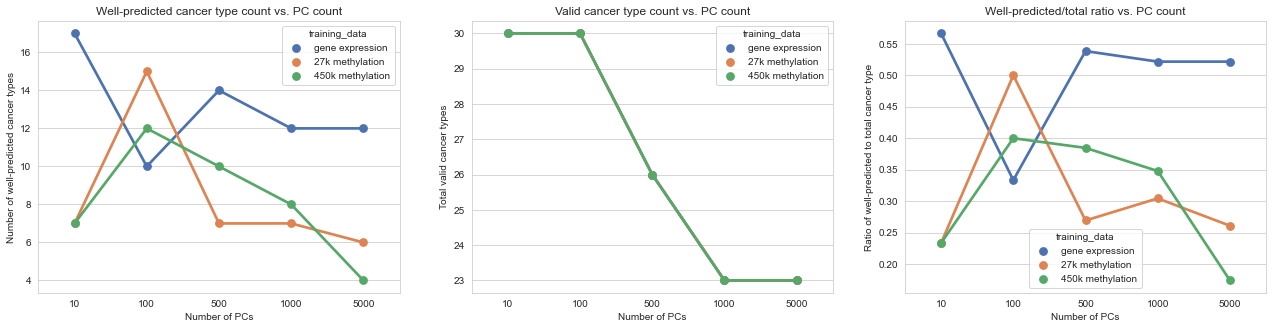

In [4]:
sns.set({'figure.figsize': (22, 5)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 3)

sns.pointplot(data=me_data_count_df, x='n_dim', y='num_reject',
              hue='training_data', hue_order=training_data_map.values(), ax=axarr[0])
axarr[0].set_xlabel('Number of PCs')
axarr[0].set_ylabel('Number of well-predicted cancer types')
axarr[0].set_title('Well-predicted cancer type count vs. PC count')

sns.pointplot(data=me_data_count_df, x='n_dim', y='num_total',
              hue='training_data', hue_order=training_data_map.values(), ax=axarr[1])
axarr[1].set_xlabel('Number of PCs')
axarr[1].set_ylabel('Total valid cancer types')
axarr[1].set_title('Valid cancer type count vs. PC count')

sns.pointplot(data=me_data_count_df, x='n_dim', y='ratio',
              hue='training_data', hue_order=training_data_map.values(), ax=axarr[2])
axarr[2].set_xlabel('Number of PCs')
axarr[2].set_ylabel('Ratio of well-predicted to total cancer type')
axarr[2].set_title('Well-predicted/total ratio vs. PC count')

In [5]:
me_performance_df = []
all_drop_cancer_types = set()

for n_dim in pcs_list:
    # load results into a single dataframe
    me_pcs_dir = Path(me_results_dir, 'results_{}_pca'.format(n_dim))
    me_results_df = su.load_survival_results(me_pcs_dir)
    me_results_df.rename(columns={'identifier': 'cancer_type',
                                  'fold_no': 'fold'}, inplace=True)
    
    me_count_df = (me_results_df[me_results_df.data_type == 'test']
        .groupby(['cancer_type', 'training_data'])
        .count()
    )
    problem_df = me_count_df[me_count_df['cindex'] != 16].copy()
    drop_cancer_types = problem_df.index.get_level_values(0).unique().values
    
    me_all_results_df = au.compare_all_data_types(
        me_results_df[~me_results_df.cancer_type.isin(drop_cancer_types)],
        SIG_ALPHA,
        filter_genes=False,
        compare_ind=True,
        identifier='cancer_type',
        metric='cindex')
    me_all_results_df.rename(columns={'gene': 'cancer_type'}, inplace=True)
    me_all_results_df['n_dim'] = n_dim
    me_performance_df.append(me_all_results_df)
    
me_performance_df = pd.concat(me_performance_df)
me_performance_df.training_data.replace(to_replace=training_data_map, inplace=True)
me_performance_df.head(10)

,cancer_type,seed,fold,delta_cindex,training_data,n_dim
0,ACC,1,0,0.30853,gene expression,10
1,ACC,1,1,0.33939,gene expression,10
2,ACC,1,2,0.46552,gene expression,10
3,ACC,1,3,0.22281,gene expression,10
4,ACC,42,0,0.31522,gene expression,10
5,ACC,42,1,0.03160,gene expression,10
6,ACC,42,2,0.36538,gene expression,10
7,ACC,42,3,0.35455,gene expression,10
8,BLCA,1,0,-0.01694,gene expression,10
9,BLCA,1,1,0.12988,gene expression,10


In [6]:
group_cancer_types = me_performance_df.groupby(['cancer_type']).count().n_dim
max_count = group_cancer_types.max()
valid_cancer_types = group_cancer_types[group_cancer_types == max_count].index
print(valid_cancer_types)

Index(['BLCA', 'BRCA', 'CESC', 'COAD', 'GBM', 'HNSC', 'KIRP', 'LAML', 'LGG',
       'LIHC', 'LUAD', 'LUSC', 'MESO', 'PAAD', 'PRAD', 'SARC', 'SKCM', 'STAD',
       'UCEC', 'UVM', 'pancancer'],
      dtype='object', name='cancer_type')


Text(0.5, 1.0, 'Performance for varying PC count, averaged over cancer types')

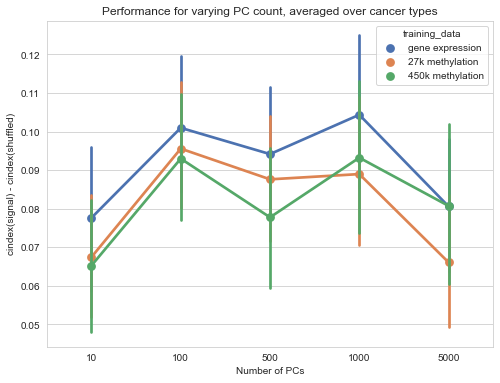

In [7]:
sns.set({'figure.figsize': (8, 6)})
sns.set_style('whitegrid')

sns.pointplot(data=me_performance_df, x='n_dim', y='delta_cindex', hue='training_data',
              hue_order=training_data_map.values())
plt.xlabel('Number of PCs')
plt.ylabel('cindex(signal) - cindex(shuffled)')
plt.title('Performance for varying PC count, averaged over cancer types')

In [8]:
cancer_type_avg = (
    me_performance_df[me_performance_df.cancer_type.isin(valid_cancer_types)]
      .groupby('cancer_type')
      .mean()
).delta_cindex
cancer_type_avg.sort_values(ascending=False).head(10)

cancer_type
KIRP         0.277228
UVM          0.184238
LGG          0.153503
SARC         0.125577
pancancer    0.122159
PRAD         0.105979
UCEC         0.099972
LUAD         0.076890
GBM          0.075978
CESC         0.075190
Name: delta_cindex, dtype: float64

In [9]:
cancer_type_sd = me_performance_df.groupby('cancer_type').std().delta_cindex
cancer_type_cv = cancer_type_avg / cancer_type_sd
cancer_type_cv.sort_values(ascending=False).head(10)

cancer_type
pancancer    3.974612
KIRP         2.109416
LGG          2.016980
SARC         1.065989
SKCM         1.062145
PRAD         1.034153
LUAD         0.959511
BLCA         0.919373
HNSC         0.909725
UCEC         0.869474
Name: delta_cindex, dtype: float64

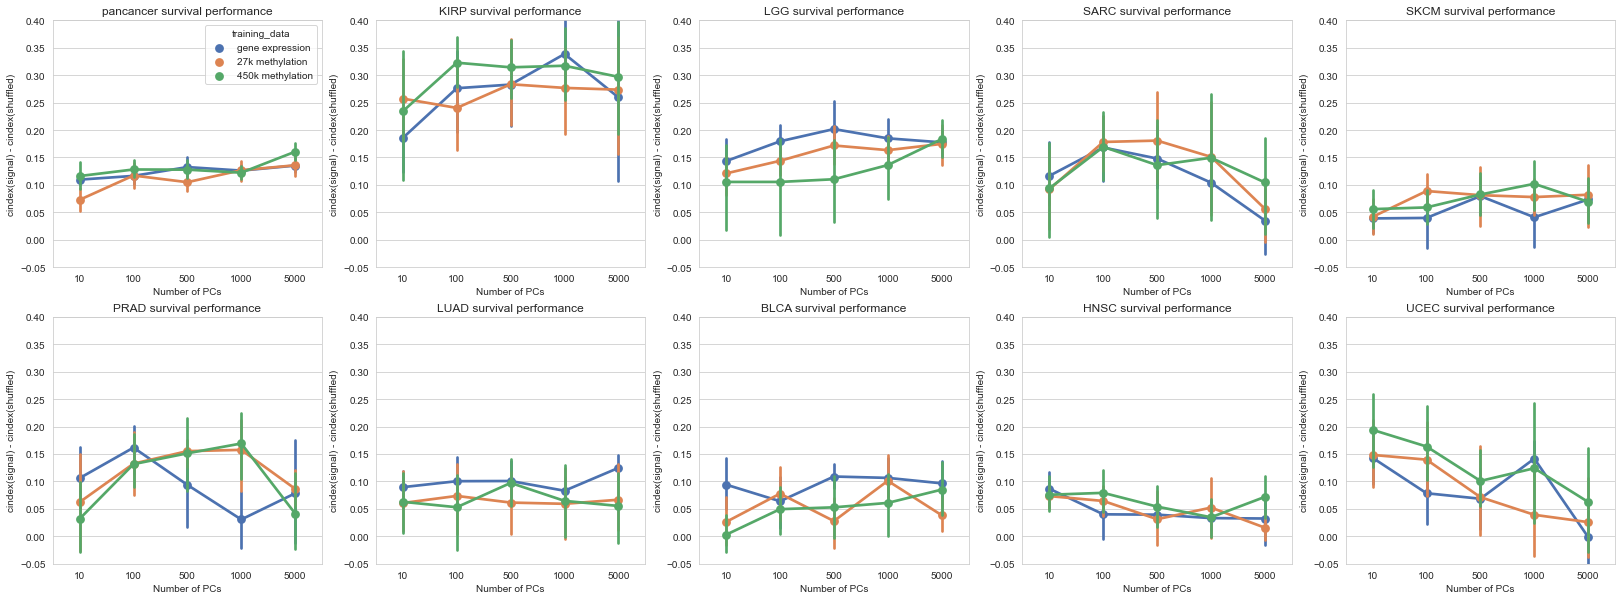

In [10]:
sns.set({'figure.figsize': (28, 10)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(2, 5)

for ix, cancer_type in enumerate(cancer_type_cv.sort_values(ascending=False).index[:10]):
    ax = axarr[ix // 5, ix % 5]
    sns.pointplot(data=me_performance_df[me_performance_df.cancer_type == cancer_type],
                  x='n_dim', y='delta_cindex', hue='training_data',
                  hue_order=training_data_map.values(), ax=ax)
    ax.set_xlabel('Number of PCs')
    ax.set_ylabel('cindex(signal) - cindex(shuffled)')
    ax.set_title('{} survival performance'.format(cancer_type))
    ax.set_ylim(-0.05, 0.4)
    if ix != 0:
        ax.get_legend().remove()

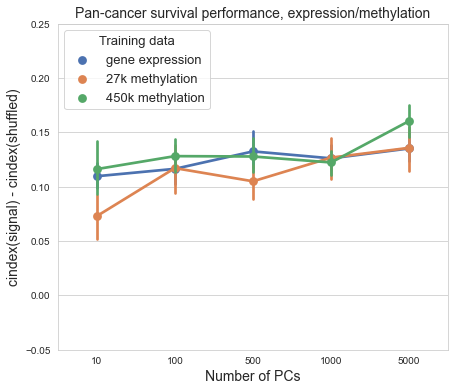

In [11]:
sns.set({'figure.figsize': (7, 6)})
sns.set_style('whitegrid')

sns.pointplot(data=me_performance_df[me_performance_df.cancer_type == 'pancancer'],
              x='n_dim', y='delta_cindex', hue='training_data', 
              hue_order=training_data_map.values())
plt.xlabel('Number of PCs', size=14)
plt.ylabel('cindex(signal) - cindex(shuffled)', size=14)
plt.legend(title='Training data', fontsize=13, title_fontsize=13)
plt.title('Pan-cancer survival performance, expression/methylation', size=14)
plt.ylim(-0.05, 0.25)

if SAVE_FIGS:
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'me_pancan_survival.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'me_pancan_survival.png',
                dpi=300, bbox_inches='tight')

### Results for all data types comparison

In [12]:
# set results directory
all_results_dir = Path(cfg.repo_root,
                      '06_predict_survival',
                      'results_all_extended_alphas')

# order to plot data types in
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
    'rppa': 'RPPA',
    'mirna': 'microRNA',
    'mut_sigs': 'mutational signatures',
}

In [13]:
all_data_count_df = []

for n_dim in pcs_list:
    # load results into a single dataframe
    all_pcs_dir = Path(all_results_dir, 'results_{}_pca'.format(n_dim))
    all_results_df = su.load_survival_results(all_pcs_dir)
    all_results_df.rename(columns={'identifier': 'cancer_type',
                                  'fold_no': 'fold'}, inplace=True)
    
    all_count_df = (all_results_df[all_results_df.data_type == 'test']
        .groupby(['cancer_type', 'training_data'])
        .count()
    )
    problem_df = all_count_df[all_count_df['cindex'] != 16].copy()
    drop_cancer_types = problem_df.index.get_level_values(0).unique().values
    
    all_all_results_df = au.compare_all_data_types(
        all_results_df[~all_results_df.cancer_type.isin(drop_cancer_types)],
        SIG_ALPHA,
        identifier='cancer_type',
        metric='cindex')
    
    print(n_dim)
    num_reject = all_all_results_df.groupby(['training_data']).sum().reject_null
    num_total = all_all_results_df.groupby(['training_data']).count().reject_null
    
    dim_count_df = (
            pd.DataFrame(num_reject).rename(columns={'reject_null': 'num_reject'})
        .merge(
            pd.DataFrame(num_total).rename(columns={'reject_null': 'num_total'})
        , left_index=True, right_index=True)
    )
    dim_count_df['n_dim'] = n_dim
    dim_count_df['ratio'] = dim_count_df.num_reject / dim_count_df.num_total
    all_data_count_df.append(dim_count_df)
    
all_data_count_df = pd.concat(all_data_count_df).reset_index()
all_data_count_df.training_data.replace(to_replace=training_data_map, inplace=True)
all_data_count_df.head(10)

10
100
500
1000
5000


,training_data,num_reject,num_total,n_dim,ratio
0,gene expression,5,24,10,0.208333
1,27k methylation,6,24,10,0.250000
2,450k methylation,9,24,10,0.375000
3,microRNA,4,24,10,0.166667
4,mutational signatures,2,24,10,0.083333
5,RPPA,4,24,10,0.166667
6,gene expression,5,23,100,0.217391
7,27k methylation,6,23,100,0.260870
8,450k methylation,5,23,100,0.217391
9,microRNA,4,23,100,0.173913


Text(0.5, 1.0, 'Well-predicted/total ratio vs. PC count')

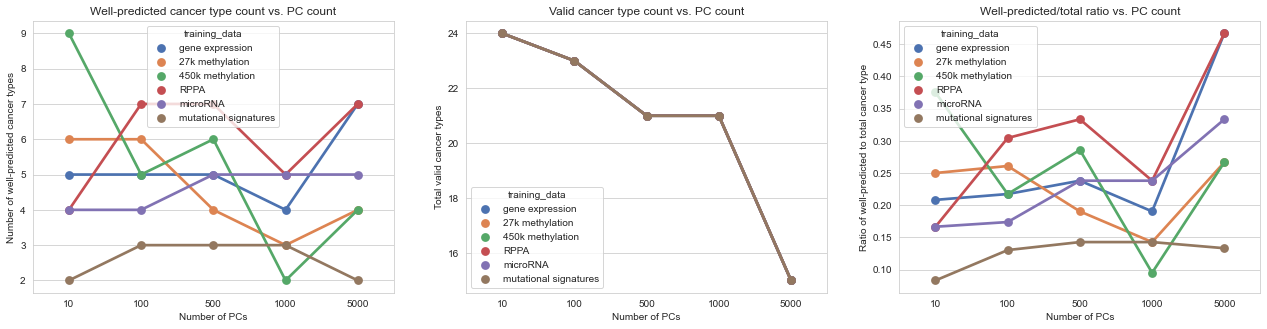

In [14]:
sns.set({'figure.figsize': (22, 5)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 3)

sns.pointplot(data=all_data_count_df, x='n_dim', y='num_reject',
              hue='training_data', hue_order=training_data_map.values(), ax=axarr[0])
axarr[0].set_xlabel('Number of PCs')
axarr[0].set_ylabel('Number of well-predicted cancer types')
axarr[0].set_title('Well-predicted cancer type count vs. PC count')

sns.pointplot(data=all_data_count_df, x='n_dim', y='num_total',
              hue='training_data', hue_order=training_data_map.values(), ax=axarr[1])
axarr[1].set_xlabel('Number of PCs')
axarr[1].set_ylabel('Total valid cancer types')
axarr[1].set_title('Valid cancer type count vs. PC count')

sns.pointplot(data=all_data_count_df, x='n_dim', y='ratio',
              hue='training_data', hue_order=training_data_map.values(), ax=axarr[2])
axarr[2].set_xlabel('Number of PCs')
axarr[2].set_ylabel('Ratio of well-predicted to total cancer type')
axarr[2].set_title('Well-predicted/total ratio vs. PC count')

In [15]:
all_performance_df = []
all_drop_cancer_types = set()

for n_dim in pcs_list:
    # load results into a single dataframe
    all_pcs_dir = Path(all_results_dir, 'results_{}_pca'.format(n_dim))
    all_results_df = su.load_survival_results(all_pcs_dir)
    all_results_df.rename(columns={'identifier': 'cancer_type',
                                  'fold_no': 'fold'}, inplace=True)
    
    all_count_df = (all_results_df[all_results_df.data_type == 'test']
        .groupby(['cancer_type', 'training_data'])
        .count()
    )
    problem_df = all_count_df[all_count_df['cindex'] != 16].copy()
    drop_cancer_types = problem_df.index.get_level_values(0).unique().values
    
    all_all_results_df = au.compare_all_data_types(
        all_results_df[~all_results_df.cancer_type.isin(drop_cancer_types)],
        SIG_ALPHA,
        filter_genes=False,
        compare_ind=True,
        identifier='cancer_type',
        metric='cindex')
    all_all_results_df.rename(columns={'gene': 'cancer_type'}, inplace=True)
    all_all_results_df['n_dim'] = n_dim
    all_performance_df.append(all_all_results_df)
    
all_performance_df = pd.concat(all_performance_df)
all_performance_df.training_data.replace(to_replace=training_data_map, inplace=True)
all_performance_df.head(10)

,cancer_type,seed,fold,delta_cindex,training_data,n_dim
0,ACC,1,0,0.35417,450k methylation,10
1,ACC,1,1,-0.33333,450k methylation,10
2,ACC,1,2,-0.25347,450k methylation,10
3,ACC,1,3,-0.83333,450k methylation,10
4,ACC,42,0,0.35714,450k methylation,10
5,ACC,42,1,0.05556,450k methylation,10
6,ACC,42,2,-0.27778,450k methylation,10
7,ACC,42,3,0.27778,450k methylation,10
8,BLCA,1,0,0.09032,450k methylation,10
9,BLCA,1,1,0.06347,450k methylation,10


In [16]:
group_cancer_types = all_performance_df.groupby(['cancer_type']).count().n_dim
max_count = group_cancer_types.max()
valid_cancer_types = group_cancer_types[group_cancer_types == max_count].index
print(valid_cancer_types)

Index(['BRCA', 'COAD', 'HNSC', 'KIRC', 'LGG', 'LIHC', 'SARC', 'SKCM', 'STAD',
       'THCA', 'UCEC', 'pancancer'],
      dtype='object', name='cancer_type')


Text(0.5, 1.0, 'Performance for varying PC count, averaged over cancer types')

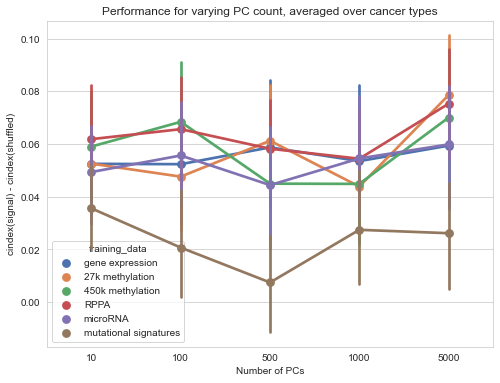

In [17]:
sns.set({'figure.figsize': (8, 6)})
sns.set_style('whitegrid')

sns.pointplot(data=all_performance_df, x='n_dim', y='delta_cindex', hue='training_data',
              hue_order=training_data_map.values())
plt.xlabel('Number of PCs')
plt.ylabel('cindex(signal) - cindex(shuffled)')
plt.title('Performance for varying PC count, averaged over cancer types')

In [18]:
cancer_type_avg = (
    all_performance_df[all_performance_df.cancer_type.isin(valid_cancer_types)]
      .groupby('cancer_type')
      .mean()
).delta_cindex
cancer_type_avg.sort_values(ascending=False).head(10)

cancer_type
KIRC         0.155701
LGG          0.151500
UCEC         0.133917
pancancer    0.087243
SARC         0.066613
COAD         0.030367
SKCM         0.027859
LIHC         0.020358
HNSC         0.019447
THCA        -0.006041
Name: delta_cindex, dtype: float64

In [19]:
cancer_type_sd = all_performance_df.groupby('cancer_type').std().delta_cindex
cancer_type_cv = cancer_type_avg / cancer_type_sd
cancer_type_cv.sort_values(ascending=False).head(10)

cancer_type
LGG          1.876250
KIRC         1.489722
pancancer    1.365543
UCEC         1.152649
SARC         0.541687
SKCM         0.282959
COAD         0.282742
HNSC         0.270555
LIHC         0.176136
THCA        -0.056535
Name: delta_cindex, dtype: float64

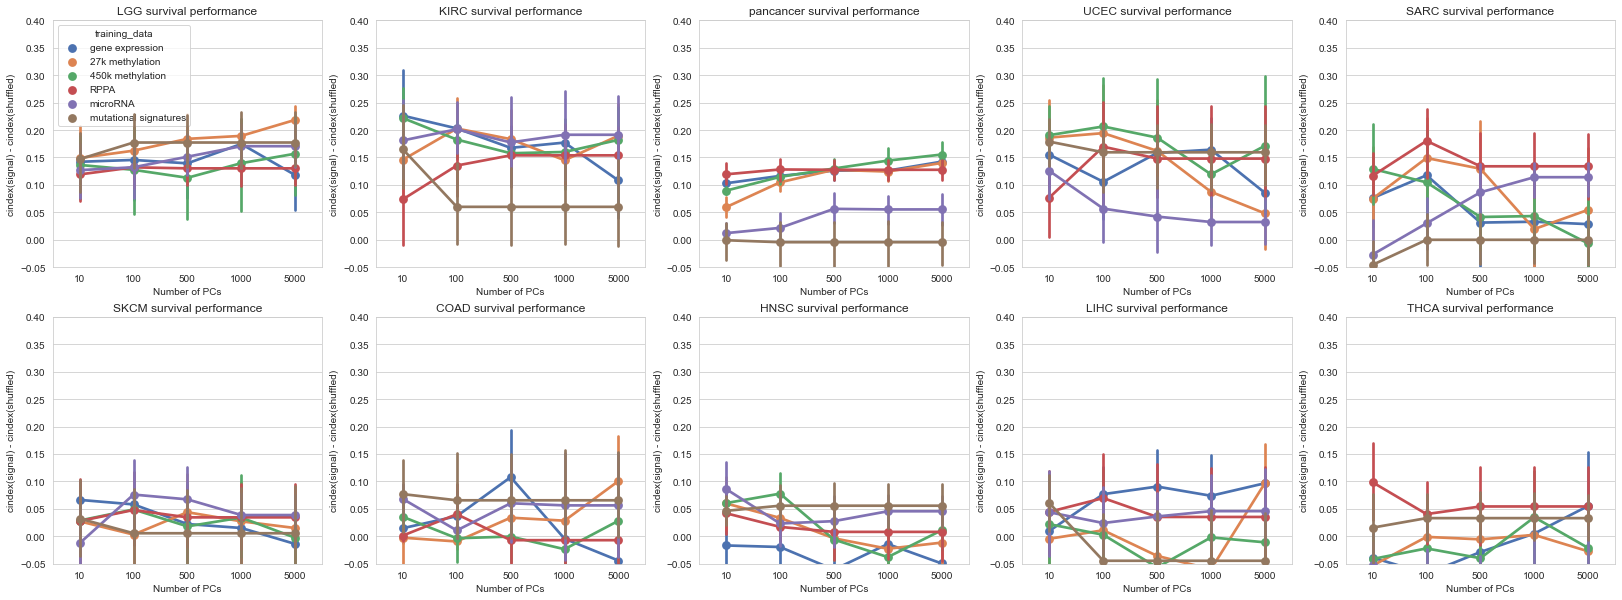

In [20]:
sns.set({'figure.figsize': (28, 10)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(2, 5)

for ix, cancer_type in enumerate(cancer_type_cv.sort_values(ascending=False).index[:10]):
    ax = axarr[ix // 5, ix % 5]
    sns.pointplot(data=all_performance_df[all_performance_df.cancer_type == cancer_type],
                  x='n_dim', y='delta_cindex', hue='training_data',
                  hue_order=training_data_map.values(), ax=ax)
    ax.set_xlabel('Number of PCs')
    ax.set_ylabel('cindex(signal) - cindex(shuffled)')
    ax.set_title('{} survival performance'.format(cancer_type))
    ax.set_ylim(-0.05, 0.4)
    if ix != 0:
        ax.get_legend().remove()

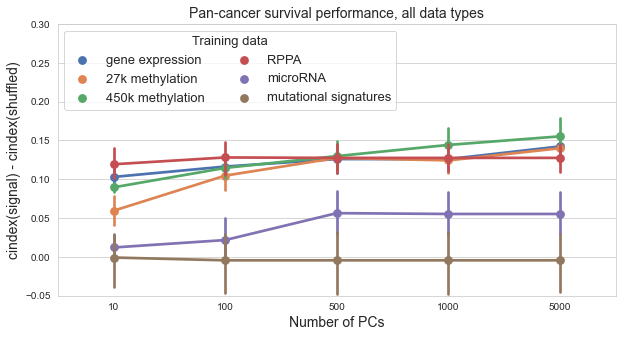

In [24]:
sns.set({'figure.figsize': (10, 5)})
sns.set_style('whitegrid')

sns.pointplot(data=all_performance_df[all_performance_df.cancer_type == 'pancancer'],
              x='n_dim', y='delta_cindex', hue='training_data', 
              hue_order=training_data_map.values())
plt.xlabel('Number of PCs', size=14)
plt.ylabel('cindex(signal) - cindex(shuffled)', size=14)
plt.legend(title='Training data', fontsize=13, title_fontsize=13, loc='upper left', ncol=2)
plt.title('Pan-cancer survival performance, all data types', size=14)
plt.ylim(-0.05, 0.3)

if SAVE_FIGS:
    plt.savefig(images_dir / 'all_pancan_survival.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_pancan_survival.png',
                dpi=300, bbox_inches='tight')